In [1]:
import pandas as pd
import numpy as np 
from textblob import TextBlob
from wordcloud import WordCloud
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
from matplotlib import gridspec

In [2]:
hc = pd.read_csv('dataHC6_tweets.csv')
bo = pd.read_csv('dataBO3_tweets.csv')
jb = pd.read_csv('dataJB3_tweets.csv')
kh = pd.read_csv('dataKH2_tweets.csv')

In [3]:
#drop duplicate row
hc.drop_duplicates(inplace=True)
bo.drop_duplicates(inplace=True)
jb.drop_duplicates(inplace=True)
kh.drop_duplicates(inplace=True)

In [4]:
df = pd.concat([hc, bo, jb,kh]).copy()
df.head(5)

,UserName,Handle,Timestamp,Tweet,Comments,Retweets,Likes
0,Hillary Clinton,@HillaryClinton,2021-10-12T13:01:27.000Z,"I hope you have as much fun reading ""State of ...",904,720,"4,515"
1,Hillary Clinton,@HillaryClinton,2021-10-27T18:59:11.000Z,Gladys Boggs has spent nearly half a century i...,67,164,"1,118"
2,Ann O'Leary,@Ann_OLeary,2021-10-25T20:36:18.000Z,The fight for a national The fight for a natio...,14,179,464
3,Hillary Clinton,@HillaryClinton,2021-10-27T17:52:55.000Z,The U.S. is one of six countries currently wit...,199,836,"2,746"
4,Hillary Clinton,@HillaryClinton,2021-10-22T16:57:00.000Z,Today’s release of the first-ever U.S. Strateg...,169,674,"2,313"


In [5]:
len(df)

1984

In [6]:
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)

    return text

In [7]:
# since the output did not include the real number of likes, retweets and comments, we have to 
# clean the object and make them become a number that we can manipulate
def cleanNum(num):
    num = re.sub(',', '', num)
    if '萬' in num:
        num = num.replace('萬', '',1)
        num = float(num)*10000
    return float(num)

In [8]:
# clean the time oject
def cleanDate(datentime):
    dateonly = datentime.split("T")
    return dateonly[0]

In [9]:
# apply the values to the function we created 
df['Tweet_clean']  = df['Tweet'].astype(str).apply(cleanTxt)

df['Comments_clean'] = df['Comments'].astype(str).apply(cleanNum)
df['Likes_clean'] = df['Likes'].astype(str).fillna(0).apply(cleanNum)
df['Retweets_clean'] = df['Retweets'].astype(str).fillna(0).apply(cleanNum)

df['date_clean'] = df['Timestamp'].apply(cleanDate)
df['date_clean'] = pd.to_datetime(df['date_clean'])

In [10]:

df.loc[df['Comments_clean'].isna(), 'Comments_clean'] = 0
df.loc[df['Likes_clean'].isna(), 'Likes_clean'] = 0
df.loc[df['Retweets_clean'].isna(), 'Retweets_clean'] = 0

In [11]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['Tweet_clean'].apply(getSubjectivity)
df['Polarity'] = df['Tweet_clean'].apply(getPolarity)

In [140]:
df.head(3)

,UserName,Handle,Timestamp,Tweet,Comments,Retweets,Likes,Tweet_clean,Comments_clean,Likes_clean,Retweets_clean,date_clean,Subjectivity,Polarity,Analysis,Original
0,Hillary Clinton,@HillaryClinton,2021-10-12T13:01:27.000Z,"I hope you have as much fun reading ""State of ...",904,720,"4,515","I hope you have as much fun reading ""State of ...",904.0,4515.0,720.0,2021-10-12,0.600000,0.462500,positive,original
1,Hillary Clinton,@HillaryClinton,2021-10-27T18:59:11.000Z,Gladys Boggs has spent nearly half a century i...,67,164,"1,118",Gladys Boggs has spent nearly half a century i...,67.0,1118.0,164.0,2021-10-27,0.208333,0.073958,positive,original
2,Ann O'Leary,@Ann_OLeary,2021-10-25T20:36:18.000Z,The fight for a national The fight for a natio...,14,179,464,The fight for a national The fight for a natio...,14.0,464.0,179.0,2021-10-25,0.000000,0.000000,neutral,not original


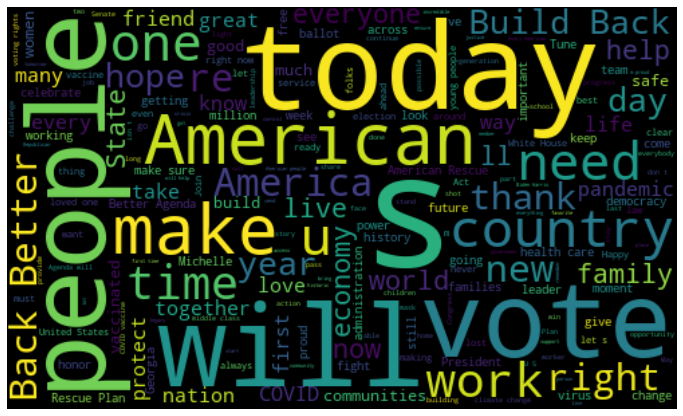

In [96]:
# plotting word cloud
allWords = ''.join([twts for twts in df['Tweet_clean'].astype(str)])
wordCloudPos = WordCloud(width = 500, height =300, random_state = 21, max_font_size =120).generate(allWords)

fig = plt.figure(figsize=(12,8))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [14]:
#Create function to compute the negative, netural and positive analysis

def getAnalysis(score):
    if score < 0:
        return 'negative'
    if score == 0:
        return 'neutral'
    else: return 'positive'

df['Analysis'] = df['Polarity'].apply(getAnalysis)

In [111]:
# create function to identify if the tweet is original or not
def original(name):
    if name == 'Hillary Clinton' or name =='Barack Obama' or name == 'Joe Biden' or name == 'Kamala Harris':
        return 'original'
    else:
        return 'not original'

df['Original'] = df['UserName'].apply(original)

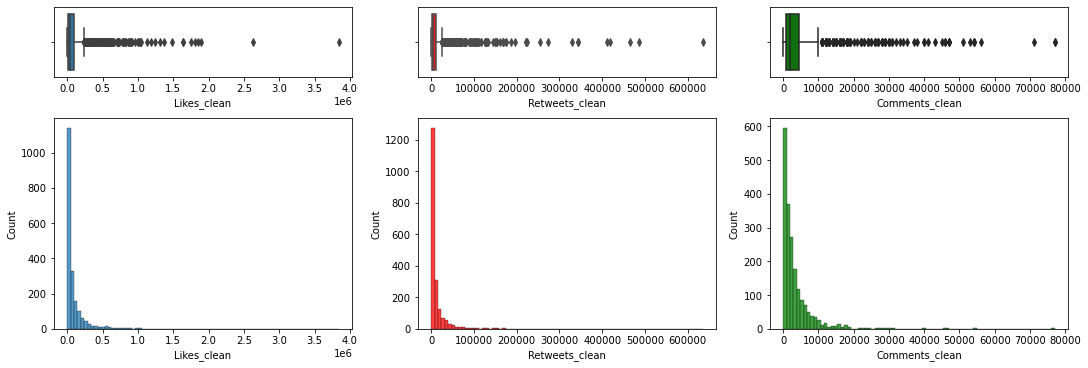

In [148]:
# create box plot and histogram to visualize the distribution of likes, retweets and comments
fig = plt.figure(constrained_layout=True, figsize=(15,5))
widths = [1, 1, 1]
heights = [1, 3]
spec5 = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths,
                          height_ratios=heights)

ax0 = fig.add_subplot(spec5[0, 0])
ax0 = sns.boxplot(x='Likes_clean', data= df, showfliers=True)

ax1 = fig.add_subplot(spec5[0, 1])
ax1 = sns.boxplot(x='Retweets_clean', data=df, showfliers=True, color='red')

ax2 = fig.add_subplot(spec5[0, 2])
ax2 = sns.boxplot(x='Comments_clean', data=df, showfliers=True, color='green')

ax3 = fig.add_subplot(spec5[1, 0])
ax3 = sns.histplot(x='Likes_clean', data=df, bins=80)

ax4 = fig.add_subplot(spec5[1, 1])
ax4 = sns.histplot(x='Retweets_clean', data=df, color='red', bins=80)

ax5 = fig.add_subplot(spec5[1, 2])
ax5 = sns.histplot(x='Comments_clean', data=df, color='green', bins=80)

In [149]:
# build a pivot table to look at the median of interactions of different type of tweets
table = pd.pivot_table(df, index=['Analysis', 'Original'], values=['Likes_clean','Retweets_clean','Comments_clean'], aggfunc={'Likes_clean': np.median,\
    'Retweets_clean': np.median, 'Comments_clean': np.median})
table.reindex(['positive','neutral','negative'], level=0, axis=0).reindex(['original','not original'], level=1, axis=0).reindex(['Likes_clean','Retweets_clean','Comments_clean'], axis=1)


Likes_clean  Retweets_clean  Comments_clean
Analysis Original                                                 
positive original          44000.0          5174.0          2266.0
         not original      31000.0          4736.0          2136.0
neutral  original          29000.0          3657.0          1781.5
         not original      24000.0          3940.0          1520.5
negative original          37000.0          5163.0          2109.5
         not original      29500.0          4209.0          2056.5